# Executive Summary
- (Project) Using deep learning to predict credit rating of companies
- Deep Learning model used = Artificial Neural Network (ANN) 
- Inputs: 75670 companies, 75 features
- Model Performance: 0.9 MAE, out of a range of 21 ratings
    
- Confusion Matrix
    - By visual inspection, predictions are accurate for most cases, difference between predicted and actual rating is about one rating (e.g. for an actual rating of 10, most predictions are between 9-11)
No significant amount of outliers
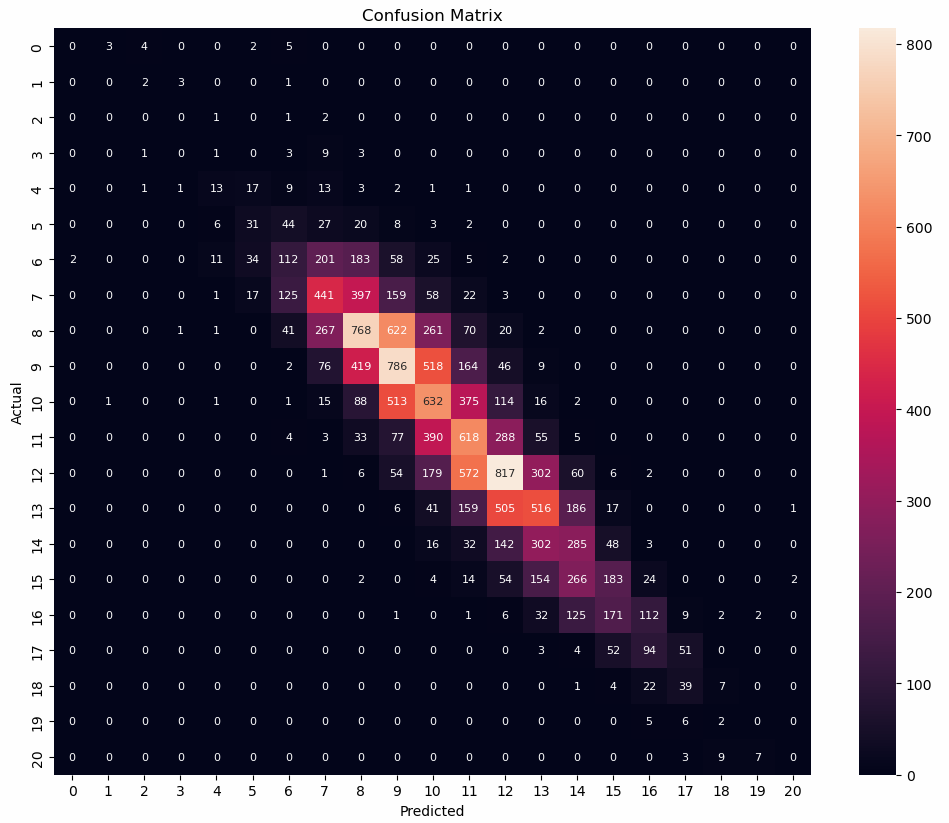

In [105]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_error
import numpy as np
pd.set_option('display.max_columns',100)
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as  sns
from sklearn.metrics import r2_score, confusion_matrix

In [55]:
df = pd.read_excel('S&P Entity Ratings - Send.xlsx')

In [31]:
df_raw = df.copy()

In [203]:
df = df.dropna()

In [206]:
drop = ['ratingsymbol','concat','gvkey','permno','Monthly date matched with adate and qdate','TICKER','cusip','Name']

In [207]:
x = df.drop(drop,axis=1)

In [208]:
y = df['ratingsymbol']

# 'Rating' variable : 
- Ordinal categorical variable
    - (Eg) let AAA = 21, AA+ = 20 etc
- System understanding 21 > 20 but not the ordinal nature
    -(Eg) if data consistently show that lower leverage ratio leads to higher credit rating, the model is likely to learn this pattern

In [209]:
rating_mapping = {
    'AAA': 21, 'AA+': 20, 'AA': 19,
    'AA-': 18, 'A+': 17, 'A': 16,
    'A-': 15, 'BBB+': 14, 'BBB': 13, 
    'BBB-': 12, 'BB+': 11, 'BB': 10,
    'BB-': 9, 'B+': 8, 'B': 7,
    'B-': 6, 'CCC+': 5, 'CCC': 4,
    'CCC-': 3, 'CC': 2, 'D': 1,
}

y = df['ratingsymbol'].map(rating_mapping)

### train_test_split(test_size = 0.2, random_state)
- Randomly pick 20% as testing set
- Inappropriate for time series data

In [254]:
X_train , X_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=0)

# **Note**: train_test_split before StandardScaler()
- we create the StandardScaler from training test, then apply the StandardScaler onto training set. This ensures that StandardScaler does not include data from training set

In [211]:
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # mean 0 , variance 1
X_test_scaled = scaler.transform(X_test) # mean not 0, std not 1

# Create Deep Learning Model
- Sequential Model
    - Sequential model in Keras is a linear stack of layers. It's called "sequential" because it allows you to create models layer-by-layer in a step-by-step fashion.
- Dense Layers:
    - Dense is a type of layer that is deeply connected, which means each neuron in a dense layer receives input from all neurons of the previous layer.
- **(1st Hidden Layer)** model.add(Dense(64,activation='relu', input_shape=(X_train_scaled.shape[1],)))
    - Adds a layer of 64 neurons
    - Input_shape = # of features in training data
    - Activation function = ReLU (Rectified Linear Unit)
        - Defined as f(x) = max(0,x)
            - If input is positive, outputs it directly
            - Else, output 0
- **(2nd Hidden Layer)** model.add(Dense(32,activation='relu'))
    - Receives inputs from the previous layer
- **(Last / Output Layer)** model.add(Dense(1))
    - For a regression task (to predict numerical value of credit rating), only 1 neuron
    - No activation function, which means its a linear layer, hence outputting the numeric prediction dirctly

# Neuron
- Each neuron performs weighted sum of its inputs, applying an activation function (if any), and pass the output to the next layer

In [213]:
model = Sequential()
model.add(Dense(64,activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))

# Compile
- Compiling a deep learning model means to configure it for training, i.e. specify how it learn from the data and how performance is evaluated
    - **Optimizer**: an algorithm used to change the attributes of the neural network ,e.g. weights and learning rate in order to reduce losses
        - **adam**: (Adaptive Moment Estimation, adam) 
            - Iteratively updates the learning rate (i.e. how much to adjust weights of neurons), unlike the fixed learning rate of traditional stochastic gradient descent (SGD). This can speed up training process, at the expense of less optimal weights
            - 
        - **Learning process**: 
            - Use current weights calc MSE loss, then use adam optimizer to update weights in a way that minimize MSE loss, repeat this process
            - **(Forward Propagation, from input layers to output layer)** At each neuron : sum of weighted inputs + bias + ReLU activation function = output
            - **(Backpropagation, from output layer to input layers)** update weights of neuron to minimize MSE loss 
        - **Weights of network**: refer to weights of x variables for each neurons
            - X_train_scaled has 37 columns
            - Dense(64) : # of weights =  37 col * 64 neurons + 64 biases 
            - Dense(32) : # of weights =  37 col * 32 neurons + 32 biases 
            - Dense(1) : # of weights =  37 col * 1 neurons + 1 biases 
   - **Loss / Cost Function (used to train model)**: train the model to minimize MSE, suitable for regression model (i.e. predicting a numeric rating)
       - mean_squared_error : for regression
       - cross_entropy : for classification tasks
   - **Metrics (used to evaluate performance, NOT used to train model)**: 
       - MAE and RMSE are popular
       - use MSE for training to heavily penalise big errors when training, but use MAE to see the average error of final prediction
       

In [214]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])

# Model.fit()
- **Epoch = 10** : pass the dataset forward and backward through the neural network for 10 times, this allows the network to learn from the data. Too few epoch leads to underfitting, too many leads to overfitting.
- **Batch_size = 32** : (e.g.) x has 10 columns and 100 rows. In the first iteration, the first 32 rows will run through the network, MSE loss will be calculated, and weights of neurons will be adjusted to decrease the MSE loss. In the second iteration, the next 32 rows will be taken, and so on. Process continue until all 100 rows are used. 100/32 = 31.3 iterations (or steps) to complete one epoch
    - **32**: is popular. Its a good balance between time and frequency of weight updates, reasonable in memory requirement, and large enough to provide good estimate of MSE loss gradient

In [215]:
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32)

Epoch 1/10
1892/1892 [==============================] - 3s 1ms/step - loss: 10.5158 - mae: 2.1224
Epoch 2/10
1892/1892 [==============================] - 2s 1ms/step - loss: 3.2848 - mae: 1.3905
Epoch 3/10
1892/1892 [==============================] - 2s 1ms/step - loss: 3.1102 - mae: 1.2711
Epoch 4/10
1892/1892 [==============================] - 2s 1ms/step - loss: 2.4913 - mae: 1.1771
Epoch 5/10
1892/1892 [==============================] - 3s 1ms/step - loss: 2.3183 - mae: 1.1254
Epoch 6/10
1892/1892 [==============================] - 2s 1ms/step - loss: 2.0600 - mae: 1.0749
Epoch 7/10
1892/1892 [==============================] - 2s 1ms/step - loss: 1.9920 - mae: 1.0455
Epoch 8/10
1892/1892 [==============================] - 2s 1ms/step - loss: 1.7607 - mae: 0.9987
Epoch 9/10
1892/1892 [==============================] - 2s 1ms/step - loss: 1.6514 - mae: 0.9714
Epoch 10/10
1892/1892 [==============================] - 2s 1ms/step - loss: 1.5991 - mae: 0.9508


In [241]:
y_predict = model.predict(X_test_scaled)

473/473 [==============================] - 1s 1ms/step


In [246]:
y_predict = np.clip(np.round(y_predict),1,21)
# np.clip : ensure all values are within specificed range. 
#    - For numbers below 1, they are turned into 1. 
#    - For numbers above 21, they are turned into 21
# np.round() : round up for >= 0.5

In [247]:
pd.DataFrame([round(predict[0]) for predict in y_predict]).value_counts()

10    2286
11    2128
12    2035
13    1997
9     1922
14    1391
8     1055
15     934
16     481
7      348
17     262
18     108
6      101
5       35
19      20
20       9
3        8
4        5
2        4
21       3
1        2
Name: count, dtype: int64

In [219]:
inverse_rating_mapping = {number:rating for rating, number in rating_mapping.items()}

predicted_ratings = [inverse_rating_mapping[number[0]] for number in rounded_predictions]

### **(Note)** :
- MSE and MAE inside model.fit() is for training set
- Use "from sklearn.metrics import mean_squared_error, mean_absolute_error" for MSE and MAE for testing set
- MSE don't make sense as squared difference of numerical rating doesn't make sense, in contrast, MAE makes sense

In [248]:
mae = mean_absolute_error(y_test, y_predict)

In [249]:
mae

0.9156865336328797

# Plot Distribution of y_test

<BarContainer object of 21 artists>

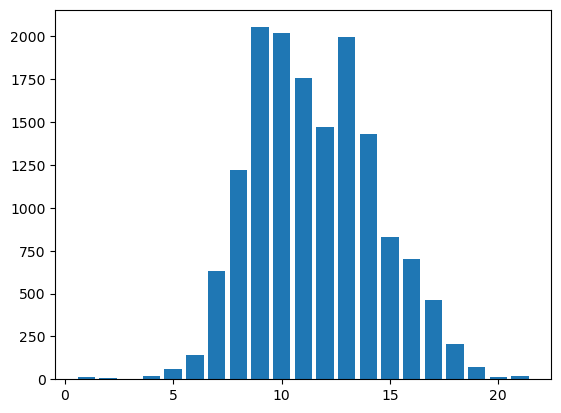

In [250]:
y_test_freq = y_test.value_counts()
y_test_freq_df = pd.DataFrame(y_test_freq).reset_index()
y_test_freq_df = y_test_freq_df.sort_values('ratingsymbol')
plt.bar(y_test_freq_df['ratingsymbol'], y_test_freq_df['count'])

# Confusion Matrix
- Typically used for classification tasks
- Treat ratings (21,20 etc) as separate class, and ignore ordinal nature (e.g. diff between 21 and 20 is less severe than 21 and 19(. Misclassifications are treated equally regardless of proximity of categories

In [251]:
pd.DataFrame([predict[0] for predict in predict_number]).value_counts()

10.0    2286
11.0    2128
12.0    2035
13.0    1997
9.0     1922
14.0    1391
8.0     1055
15.0     934
16.0     481
7.0      348
17.0     262
18.0     108
6.0      101
5.0       35
19.0      20
20.0       9
3.0        8
4.0        5
2.0        4
21.0       3
1.0        2
Name: count, dtype: int64

In [262]:
y_test.value_counts()

ratingsymbol
9     2053
10    2020
13    1999
11    1758
12    1473
14    1431
8     1223
15     828
16     703
7      633
17     461
18     204
6      141
19      73
5       61
21      19
4       17
1       14
20      13
2        6
3        4
Name: count, dtype: int64

Text(0.5, 1.0, 'Confusion Matrix')

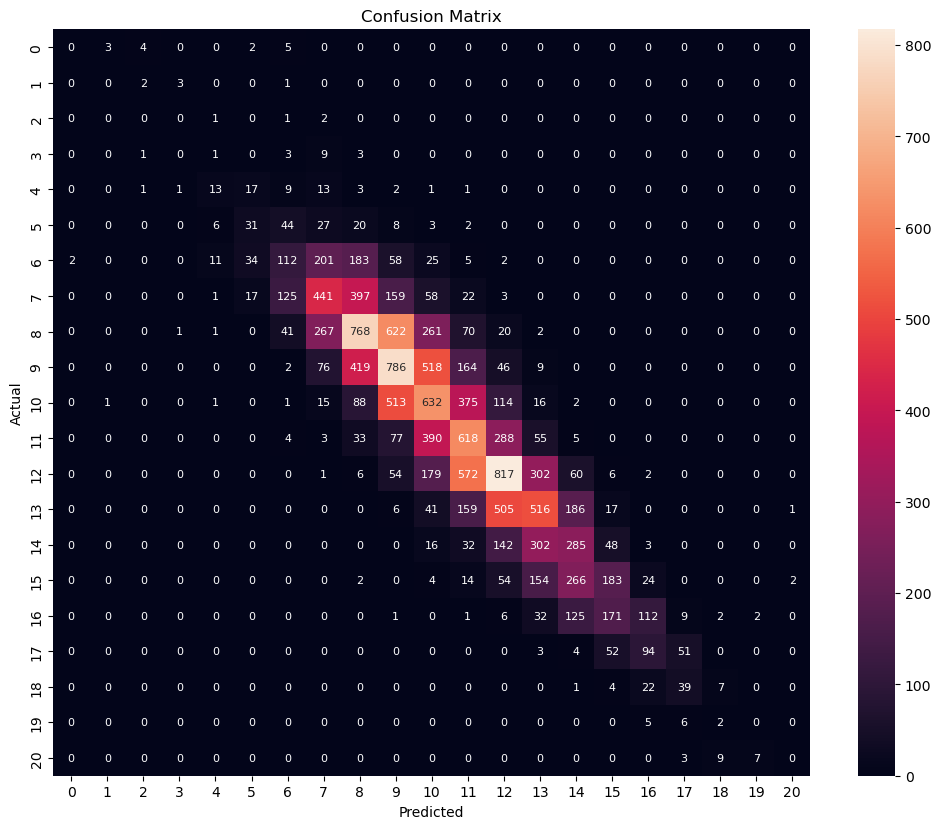

In [265]:
plt.figure(figsize=(10, 8))  # You can adjust the size as needed
sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 8})  # Adjust size as needed
plt.tight_layout()

cm = confusion_matrix(y_test, y_predict.flatten())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

<font color="red" size="5"> Analysis:
- By visual inspection, predictions are accurate for most cases, difference between predicted and actual rating is about one rating (e.g. for an actual rating of 10, most predictions are between 9-11)
- No significant amount of outliers

# Further

## Deep Learning
- Deep Learning
    - Reinforcement Learning (RL) (eg develop trading strategy, portfolio mgmt., optimize trade execution) (82x)
    - Feedforward Neural Networks (FNN) / Multilayer Perceptrons (MLP) (e.g. predict stock price) (577)
    - Convolutional Neural Networks (CNN) (e.g. HFT pattern recognition in time series data) (768)
    - Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM) (e.g. predict stock price) (758) 
    - Autoencoders (e.g. Anomaly detection in trading patterns, feature extraction and dimensionality reduction) (666)
    - Generative Adversarial Networks (GAN) (e.g. simulate market scenarios) (937)
    - Transformer Networks (e.g., sentimental analysis of analyse news and social media) (949)
- Grading Factor (out of 10, 10 is most desirable)
    - Cutting-edge : 10 means more advanced tech
    - Time required : 10 means complicated, time consuming to train
    - Accuracy